# Optional functions

In [1]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


Loading data 

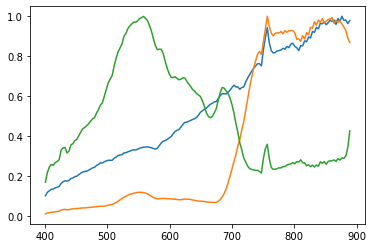

In [2]:
dataset = "Samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

plot(wavelength, spectra[0])
plot(wavelength, spectra[1])
plot(wavelength, spectra[2])


plt.show()

N,M,P = a_map.shape
_,_,K = hypercube.shape

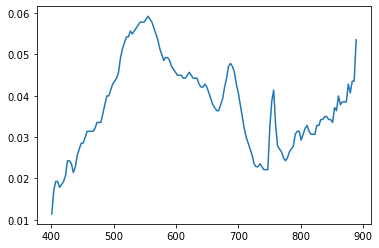

In [3]:
plot(wavelength, hypercube[20,20,:])

In [4]:
predicted_NNLS = abundance_maps.amaps.NNLS(hypercube.reshape((N*M,K)), spectra) # (N*M x P)
accuracy_NNLS = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted_NNLS)**2))
accuracy_NNLS

0.33164958064270494

# Denoising using cv2 (operate on a_map, post_processing)

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def denoising_cv (hypercube,abundance_map, endmembers):
    N,M,P = abundance_map.shape
    _,_,K = hypercube.shape
    images = zeros((N,M,P))
    
    for i in range(P):
        predicted_NNLS = abundance_maps.amaps.NNLS(hypercube.reshape((N*M,K)), spectra) # (N*M x P)
        images[:,:,i] = (255*(predicted_NNLS[:,i]/max(predicted_NNLS[:,i]))).reshape(N,M)
        image_gray = images[:,:,i].reshape(N,M)
        image_gray = np.uint8(image_gray)
        images_clean = cv2.fastNlMeansDenoising(image_gray)
        images[:,:,i] = images_clean/255
    
    return images

In [ ]:
images = denoising_cv (hypercube,a_map, spectra)

In [ ]:
accuracy_denoising = sqrt(mean((a_map.reshape((N*M,len(spectra)))-images.reshape((N*M,len(spectra))))**2))
accuracy_denoising

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]

f1= a_map[30:50,20:40,0].reshape(20*20)
f2 = images[30:50,20:40,0].reshape(20*20)
f3 = predicted_NNLS.reshape(N,M,P)
f3 = f3[30:50,20:40,0].reshape(20*20)

f1 = f1.tolist()
f2 = f2.tolist()
f3 = f3.tolist()

plt.plot(f1,'x')
plt.plot(f2,'o')
plt.plot(f3,'o')

title('cv2_noise_reduction_Samson')



# Hypercube Noise Reduction (pre_processing)

In [ ]:
from scipy.signal import lfilter

def hypercube_noise_reduction(hypercube,smoother_factor_n = 15.,smoother_factor_a = 1.):
    N,M,K = hypercube.shape
    P,_ = endmembers.shape
    
    
    hyper_s = hypercube.reshape(N*M,K)
    n = smoother_factor_n 
    b = [1.0 / n] * n
    a = smoother_factor_a
    
    for i in range (N*M):
        y = hyper_s[i,:]
        yy = lfilter(b,a,y)
        hyper_s[i,:] = yy

    
    hyper_s = hyper_s.reshape((N,M,K))
    
    
    return hyper_s

In [ ]:
hyper_SS = hypercube_noise_reduction(hypercube,smoother_factor_n = 5, smoother_factor_a = 1)

In [ ]:
hyper_SS.shape

In [ ]:
spectra.shape

In [ ]:
predicted_NNLS_nd = abundance_maps.amaps.NNLS(hyper_SS.reshape((N*M,K)), spectra) 
accuracy_NNLS_nd = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted_NNLS_nd)**2))
accuracy_NNLS_nd

In [ ]:
plt.plot(wavelength,hypercube[20,20,:],'b')
plt.plot(wavelength,hyper_SS[20,20,:],'r')

title('Samson')

# Sobel and acceleration methods 

In [ ]:
def sobel(img, threshold):
    '''
    edge detection based on sobel
    threshold (0,1)
    '''
    G_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    G_y = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    for i in range(0, rows - 2):
        for j in range(0, columns - 2):
            v = sum(sum(G_x * img[i:i+3, j:j+3]))  # vertical
            h = sum(sum(G_y * img[i:i+3, j:j+3]))  # horizon
            mag[i+1, j+1] = np.sqrt((v ** 2) + (h ** 2))
            
    for p in range(0, rows):
        for q in range(0, columns):
            if mag[p, q] < threshold:
                mag[p, q] = 0
    return mag

In [ ]:
def tiles (img, t, u):
    '''
    t = tile_size
    u: percentage_of_edge_pixels
    '''
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    sub_area = np.zeros((t,t))      
    for p in range(0, rows):
        for q in range(0, columns):
            sub_area = img[p:p+t,q:q+t]
            area_sum = sum(sub_area)
            if area_sum > t*t*u:
                mag[p, q] = 1
    return mag

In [ ]:
def acc_sobel_method (hypercube,l = 0.2,T = 2,U = 1):
    
    #normalized, called Mean removal algorithm in the ref paper
    hypercube = hypercube/sqrt(mean(hypercube**2))
    
    #taking sobel, detetcting edge
    sobel_img = np.zeros(hypercube.shape)
    for i in range(hypercube.shape[2]):
        sobel_img[:,:,i] = sobel(hypercube[:,:,i], l)
    
    # tiles,filled in color in to each sub-area
    tiles_img = np.zeros(hypercube.shape)
    for i in range(hypercube.shape[2]):
        tiles_img[:,:,i] = tiles(sobel_img[:,:,i],T,U)
        
    return tiles_img

In [ ]:
tiles_img = acc_sobel_method (hypercube)

In [ ]:
predicted_origin = abundance_maps.amaps.NNLS(hypercube.reshape((N*M,K)), spectra) # (N*M x P)
accuracy_origin = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted_origin)**2))

predicted_tiles = abundance_maps.amaps.NNLS(tiles_img.reshape((N*M,K)), spectra) # (N*M x P)
accuracy_tiles = sqrt(mean((a_map_s.reshape((N*M,len(spectra)))-predicted_tiles)**2))

In [ ]:
accuracy_origin

In [ ]:
accuracy_tiles